In [2]:
import numpy as np
import pickle as pk 
import pandas as pd
import seaborn as sn
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [3]:
X_train = np.load('../numpy/X_train.npy')
X_test = np.load('../numpy/X_val.npy')
y_train = np.load('../numpy/y_train.npy')
y_test = np.load('../numpy/y_val.npy')

In [4]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32547, 48, 48, 1) (8146, 48, 48, 1)
(32547, 8) (8146, 8)


In [112]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(48, 48, 1), activity_regularizer=l2(1e-7), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(5, 5), activity_regularizer=l2(1e-7), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, kernel_size=(3, 3), activity_regularizer=l2(1e-7), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, kernel_size=(3, 3), activity_regularizer=l2(1e-7), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activity_regularizer=l2(1e-7)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation("relu"))

model.add(Dense(512, activity_regularizer=l2(1e-7)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation("relu"))

model.add(Dense(7, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_141 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_141 (Activation)  (None, 48, 48, 64)       0         
                                                                 
 dropout_137 (Dropout)       (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_108 (Conv2D)         (None, 24, 24, 128)     

In [113]:
k_fold = KFold(n_splits=5)

In [114]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2   
)

### Attempt - 01
#### K-Fold=5, EpochsPerFold=15

In [115]:
fold_metrics = {}

for fold_no, (train, test) in enumerate(k_fold.split(X_train, y_train)):
    fold_metrics[fold_no] = {
        'loss': None,
        'val_loss': None,
        'acc': None,
        'val_acc': None
    }

    best_loss_checkpoint = ModelCheckpoint(
        filepath=f'../models/Fold_{fold_no}-best_loss_model.h5',
        monitor='loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    best_val_loss_checkpoint = ModelCheckpoint(
        filepath=f'../models/Fold_{fold_no}-best_val_loss_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5
    )

    print(f'Training Fold: {fold_no}')

    history = model.fit(
        datagen.flow(X_train[train], y_train[train], shuffle=True), 
        validation_data=(X_train[test], y_train[test]),
        batch_size=128, 
        epochs=15, 
        verbose=1,
        callbacks=[best_loss_checkpoint, best_val_loss_checkpoint, early_stopping]
    )
    
    fold_metrics[fold_no]['loss'] = history.history['loss']
    fold_metrics[fold_no]['val_loss'] = history.history['val_loss']
    fold_metrics[fold_no]['acc'] = history.history['accuracy']
    fold_metrics[fold_no]['val_acc'] = history.history['val_accuracy']

    model.load_weights(f'../models/Fold_{fold_no}-best_val_loss_model.h5')
    loss, acc = model.evaluate(X_test, y_test, verbose=1)

    print(f'Best val_loss model evaluation metrics: loss={loss}, accuracy={acc}')
    print()

Training Fold: 0
Epoch 1/15
549/549 [==============================] - 696s 1s/step - loss: 2.0413 - accuracy: 0.3039 - val_loss: 1.7832 - val_accuracy: 0.2676
Epoch 2/15
549/549 [==============================] - 644s 1s/step - loss: 1.5356 - accuracy: 0.4334 - val_loss: 1.5119 - val_accuracy: 0.4423
Epoch 3/15
549/549 [==============================] - 656s 1s/step - loss: 1.4153 - accuracy: 0.4777 - val_loss: 1.4119 - val_accuracy: 0.4805
Epoch 4/15
549/549 [==============================] - 674s 1s/step - loss: 1.3682 - accuracy: 0.4941 - val_loss: 1.3857 - val_accuracy: 0.4796
Epoch 5/15
549/549 [==============================] - 667s 1s/step - loss: 1.3221 - accuracy: 0.5191 - val_loss: 1.4226 - val_accuracy: 0.4471
Epoch 6/15
549/549 [==============================] - 668s 1s/step - loss: 1.3048 - accuracy: 0.5265 - val_loss: 1.5253 - val_accuracy: 0.4666
Epoch 7/15
549/549 [==============================] - 669s 1s/step - loss: 1.2957 - accuracy: 0.5354 - val_loss: 1.3192 - val

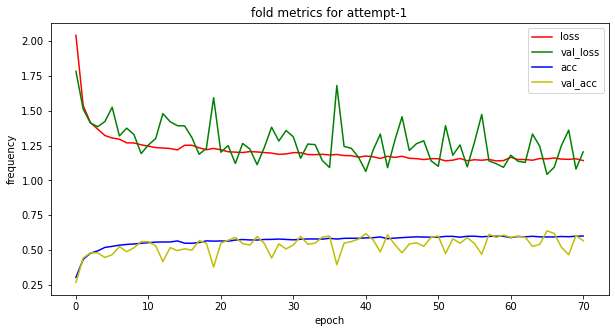

In [138]:
losses = []
accs = []
val_losses = []
val_accs = []

for fold_no in range(len(fold_metrics)):
    losses.extend(fold_metrics[fold_no]['loss'])
    val_losses.extend(fold_metrics[fold_no]['val_loss'])
    accs.extend(fold_metrics[fold_no]['acc'])
    val_accs.extend(fold_metrics[fold_no]['val_acc'])

plt.figure(figsize=(10, 5))
plt.plot(losses, 'r-', label='loss')
plt.plot(val_losses, 'g-', label='val_loss')
plt.plot(accs, 'b-', label='acc')
plt.plot(val_accs, 'y-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.title('fold metrics for attempt-1')
plt.legend()
plt.savefig('fold metrics/attempt-1/train summary.jpg')
plt.show()

In [133]:
fold_metric_file = open('fold metrics/attempt-1/fold_metric_dict.bin', 'wb')

pk.dump(fold_metrics, fold_metric_file)
fold_metric_file.close()

In [139]:
model.load_weights('../models/Fold_4-best_val_loss_model.h5')
model.evaluate(X_test, y_test, verbose=1)

77/77 [==============================] - 18s 230ms/step - loss: 1.1016 - accuracy: 0.6221


[1.101641297340393, 0.6221311688423157]

### Attempt - 02
#### K-Fold=5, EpochsPerFold=30, Limit Image Augmentation, Disable Early Stopping

In [169]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1   
)

In [171]:
model.load_weights('../models/Fold_4-best_val_loss_model.h5')

In [174]:
fold_metrics = {}

for fold_no, (train, test) in enumerate(k_fold.split(X_train, y_train)):
    fold_metrics[fold_no] = {
        'loss': None,
        'val_loss': None,
        'acc': None,
        'val_acc': None
    }

    best_loss_checkpoint = ModelCheckpoint(
        filepath=f'../models/Fold_{fold_no}-best_loss_model.h5',
        monitor='loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    best_val_loss_checkpoint = ModelCheckpoint(
        filepath=f'../models/Fold_{fold_no}-best_val_loss_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=5
    # )

    print(f'Training Fold: {fold_no}')

    history = model.fit(
        datagen.flow(X_train[train], y_train[train], shuffle=True), 
        validation_data=(X_train[test], y_train[test]),
        steps_per_epoch=X_train[train].shape[0] // 128, 
        batch_size=128, 
        epochs=30,
        verbose=1,
        callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
    )
    
    fold_metrics[fold_no]['loss'] = history.history['loss']
    fold_metrics[fold_no]['val_loss'] = history.history['val_loss']
    fold_metrics[fold_no]['acc'] = history.history['accuracy']
    fold_metrics[fold_no]['val_acc'] = history.history['val_accuracy']

    model.load_weights(f'../models/Fold_{fold_no}-best_val_loss_model.h5')
    loss, acc = model.evaluate(X_test, y_test, verbose=1)

    print(f'Best val_loss model evaluation metrics: loss={loss}, accuracy={acc}')
    print()

    model.load_weights(f'../models/Fold_{fold_no}-best_loss_model.h5')

Training Fold: 0
Epoch 1/30
137/137 [==============================] - 196s 1s/step - loss: 1.0639 - accuracy: 0.6257 - val_loss: 1.0346 - val_accuracy: 0.6386
Epoch 2/30
137/137 [==============================] - 204s 1s/step - loss: 1.0677 - accuracy: 0.6261 - val_loss: 1.0543 - val_accuracy: 0.6327
Epoch 3/30
137/137 [==============================] - 197s 1s/step - loss: 1.0723 - accuracy: 0.6414 - val_loss: 1.2679 - val_accuracy: 0.5575
Epoch 4/30
137/137 [==============================] - 203s 1s/step - loss: 1.0609 - accuracy: 0.6220 - val_loss: 1.2916 - val_accuracy: 0.5079
Epoch 5/30
137/137 [==============================] - 197s 1s/step - loss: 1.0536 - accuracy: 0.6445 - val_loss: 1.1582 - val_accuracy: 0.5939
Epoch 6/30
137/137 [==============================] - 194s 1s/step - loss: 1.0684 - accuracy: 0.6257 - val_loss: 1.1045 - val_accuracy: 0.6220
Epoch 7/30
137/137 [==============================] - 211s 2s/step - loss: 1.0961 - accuracy: 0.6309 - val_loss: 1.1102 - val

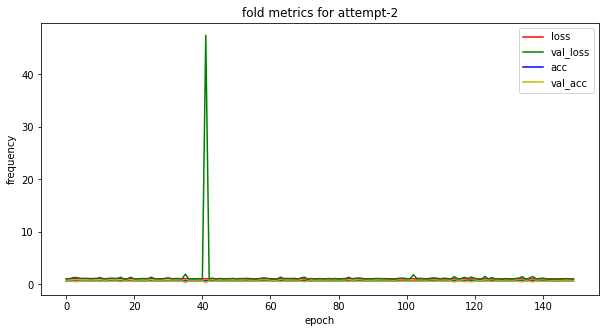

In [175]:
losses = []
accs = []
val_losses = []
val_accs = []

for fold_no in range(len(fold_metrics)):
    losses.extend(fold_metrics[fold_no]['loss'])
    val_losses.extend(fold_metrics[fold_no]['val_loss'])
    accs.extend(fold_metrics[fold_no]['acc'])
    val_accs.extend(fold_metrics[fold_no]['val_acc'])

plt.figure(figsize=(10, 5))
plt.plot(losses, 'r-', label='loss')
plt.plot(val_losses, 'g-', label='val_loss')
plt.plot(accs, 'b-', label='acc')
plt.plot(val_accs, 'y-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.title('fold metrics for attempt-2')
plt.legend()
plt.savefig('fold metrics/attempt-2/train summary.jpg')
plt.show()

In [ ]:
fold_metric_file = open('fold metrics/attempt-2/fold_metric_dict.bin', 'wb')

pk.dump(fold_metrics, fold_metric_file)
fold_metric_file.close()

In [176]:
model.load_weights('../models/Fold_1-best_val_loss_model.h5')
model.evaluate(X_test, y_test, verbose=1)

77/77 [==============================] - 17s 221ms/step - loss: 1.0364 - accuracy: 0.6193


[1.036434292793274, 0.6192622780799866]

In [177]:
predictions = model.predict(X_test)

In [179]:
confusion = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(predictions, axis=1)
)
print(confusion)

[[132   0   7  31 120  11  11]
 [ 28  12   3   8   8   2   2]
 [ 18   0  53  23  78   7  31]
 [  8   0   3 643  68   7   5]
 [ 20   0   6  27 364  20   5]
 [ 37   1  10  21 203  93   2]
 [  7   0  20  31  38   2 214]]


<AxesSubplot:xlabel='predicted', ylabel='actual'>

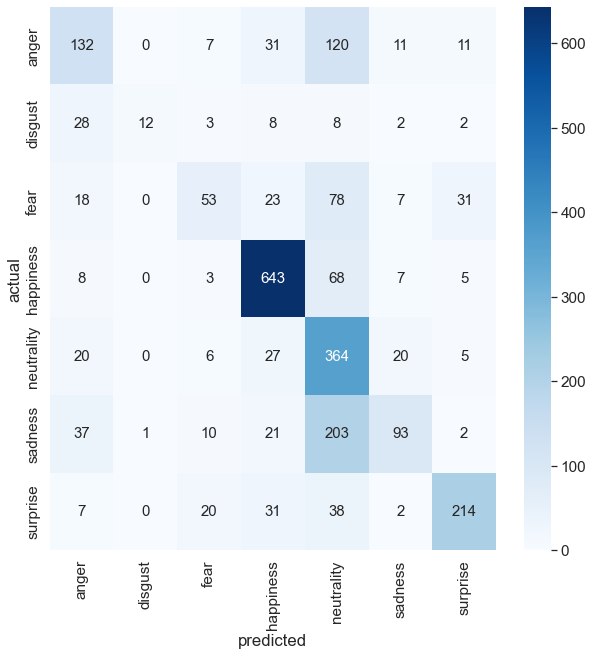

In [183]:
labels = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (10, 10))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")

### Attempt - 03
#### VGG16 CNN Architecture Implementation

In [32]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block1_conv1', input_shape=(48, 48, 1) ))
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block1_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv1'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv1'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv2'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv1'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv2'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv1'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv2'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_maxpool (MaxPooling2  (None, 24, 24, 64)       0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_maxpool (MaxPooling2  (None, 12, 12, 128)      0         
 D)                                                   

In [4]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=1,
)

Epoch 1/30
687/687 [==============================] - 1576s 2s/step - loss: 1.6908 - accuracy: 0.3523 - val_loss: 1.5631 - val_accuracy: 0.4098
Epoch 2/30
687/687 [==============================] - 1642s 2s/step - loss: 1.3828 - accuracy: 0.4746 - val_loss: 1.2667 - val_accuracy: 0.5270
Epoch 3/30
687/687 [==============================] - 1746s 3s/step - loss: 1.2146 - accuracy: 0.5391 - val_loss: 1.1447 - val_accuracy: 0.5705
Epoch 4/30
687/687 [==============================] - 1641s 2s/step - loss: 1.0951 - accuracy: 0.5869 - val_loss: 1.1120 - val_accuracy: 0.5738
Epoch 5/30
687/687 [==============================] - 1584s 2s/step - loss: 1.0013 - accuracy: 0.6213 - val_loss: 1.0898 - val_accuracy: 0.6123
Epoch 6/30
687/687 [==============================] - 1680s 2s/step - loss: 0.9190 - accuracy: 0.6535 - val_loss: 1.0208 - val_accuracy: 0.6250
Epoch 7/30
687/687 [==============================] - 1743s 3s/step - loss: 0.8381 - accuracy: 0.6897 - val_loss: 1.0099 - val_accuracy:

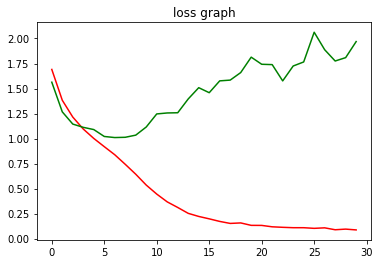

In [5]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'g')
plt.title('loss graph')
plt.show()

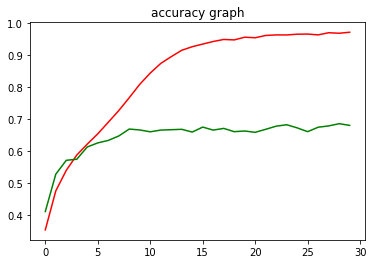

In [6]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'g')
plt.title('accuracy graph')
plt.show()

In [7]:
model.save_weights('../models/VGG16-best_loss_model.h5')

### Attempt - 04
#### VGG16 CNN Architecture Implementation + Image Augmentation

In [14]:
model.load_weights('../models/VGG16-best_loss_model.h5')

In [15]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2
)

In [8]:
best_loss_checkpoint = ModelCheckpoint(
    filepath=f'../models/VGG16-best_loss_model.h5',
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath=f'../models/VGG16-best_val_loss_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [18]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=1,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/30
687/687 [==============================] - 1631s 2s/step - loss: 1.0415 - accuracy: 0.6308 - val_loss: 0.9034 - val_accuracy: 0.6980
Epoch 2/30
687/687 [==============================] - 1632s 2s/step - loss: 0.9505 - accuracy: 0.6588 - val_loss: 0.8804 - val_accuracy: 0.6902
Epoch 3/30
687/687 [==============================] - 1662s 2s/step - loss: 0.9033 - accuracy: 0.6701 - val_loss: 0.8759 - val_accuracy: 0.7008
Epoch 4/30
687/687 [==============================] - 1601s 2s/step - loss: 0.8809 - accuracy: 0.6817 - val_loss: 0.8473 - val_accuracy: 0.6996
Epoch 5/30
687/687 [==============================] - 1586s 2s/step - loss: 0.8579 - accuracy: 0.6875 - val_loss: 0.9243 - val_accuracy: 0.6652
Epoch 6/30
687/687 [==============================] - 1537s 2s/step - loss: 0.8411 - accuracy: 0.6922 - val_loss: 0.8322 - val_accuracy: 0.7131
Epoch 7/30
687/687 [==============================] - 1535s 2s/step - loss: 0.8179 - accuracy: 0.7016 - val_loss: 0.8593 - val_accuracy:

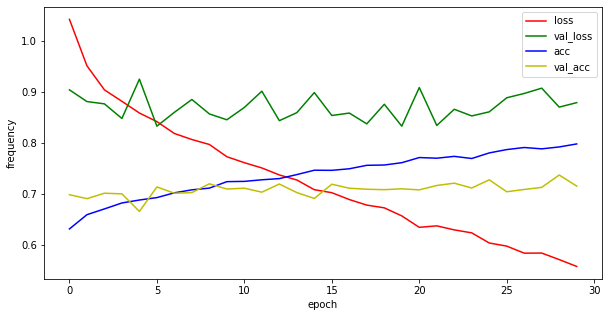

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'g-', label='val_loss')
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'y-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.legend()
plt.show()

### Attempt - 05
#### VGG16 CNN Architecture Implementation + Image Augmentation + Expanded Dropouts

In [5]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block1_conv1', input_shape=(48, 48, 1) ))
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-7), kernel_initializer='he_uniform', name='block1_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv1'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv1'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv2'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv1'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv2'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))

model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv1'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv2'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_maxpool (MaxPooling2  (None, 24, 24, 64)       0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_maxpool (MaxPooling2  (None, 12, 12, 128)      0         
 D)                                                     

In [12]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [13]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=1,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/30
1018/1018 [==============================] - 4728s 5s/step - loss: 1.8775 - accuracy: 0.2501 - val_loss: 1.7494 - val_accuracy: 0.2849
Epoch 2/30
1018/1018 [==============================] - 4929s 5s/step - loss: 1.7553 - accuracy: 0.2836 - val_loss: 1.6528 - val_accuracy: 0.3102
Epoch 3/30
1018/1018 [==============================] - 3117s 3s/step - loss: 1.7028 - accuracy: 0.3048 - val_loss: 1.6826 - val_accuracy: 0.2951
Epoch 4/30
1018/1018 [==============================] - 2614s 3s/step - loss: 1.6234 - accuracy: 0.3444 - val_loss: 1.4389 - val_accuracy: 0.4170
Epoch 5/30
1018/1018 [==============================] - 2611s 3s/step - loss: 1.4987 - accuracy: 0.4011 - val_loss: 1.4007 - val_accuracy: 0.4416
Epoch 6/30
1018/1018 [==============================] - 2614s 3s/step - loss: 1.4051 - accuracy: 0.4474 - val_loss: 1.2965 - val_accuracy: 0.4795
Epoch 7/30
1018/1018 [==============================] - 2601s 3s/step - loss: 1.3347 - accuracy: 0.4790 - val_loss: 1.3108 -

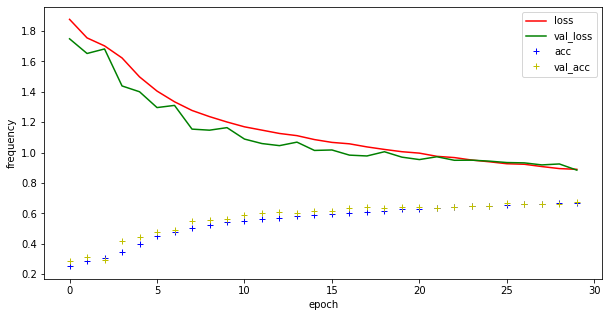

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'g-', label='val_loss')
plt.plot(history.history['accuracy'], 'b+', label='acc')
plt.plot(history.history['val_accuracy'], 'y+', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [15]:
model.load_weights('../models/VGG16-best_loss_model.h5')

In [16]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=70,
    verbose=1,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/70
1018/1018 [==============================] - 2539s 2s/step - loss: 0.8785 - accuracy: 0.6757 - val_loss: 0.9050 - val_accuracy: 0.6754
Epoch 2/70
1018/1018 [==============================] - 2543s 2s/step - loss: 0.8715 - accuracy: 0.6756 - val_loss: 0.9088 - val_accuracy: 0.6688
Epoch 3/70
1018/1018 [==============================] - 2543s 2s/step - loss: 0.8596 - accuracy: 0.6800 - val_loss: 0.8759 - val_accuracy: 0.6816
Epoch 4/70
1018/1018 [==============================] - 2542s 2s/step - loss: 0.8555 - accuracy: 0.6831 - val_loss: 0.9252 - val_accuracy: 0.6650
Epoch 5/70
1018/1018 [==============================] - 2652s 3s/step - loss: 0.8491 - accuracy: 0.6857 - val_loss: 0.9092 - val_accuracy: 0.6688
Epoch 6/70
1018/1018 [==============================] - 2514s 2s/step - loss: 0.8353 - accuracy: 0.6901 - val_loss: 0.9320 - val_accuracy: 0.6781
Epoch 7/70
1018/1018 [==============================] - 2513s 2s/step - loss: 0.8231 - accuracy: 0.6951 - val_loss: 0.9185 -

In [9]:
model.load_weights('../models/VGG16-best_loss_model.h5')

In [6]:
best_loss_checkpoint = ModelCheckpoint(
    filepath=f'../models/VGG16-best_loss_model.h5',
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath=f'../models/VGG16-best_val_loss_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [11]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=70,
    initial_epoch=48,
    verbose=1,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 49/70
1018/1018 [==============================] - 2450s 2s/step - loss: 0.7790 - accuracy: 0.7465 - val_loss: 0.9639 - val_accuracy: 0.6915
Epoch 50/70
1018/1018 [==============================] - 2433s 2s/step - loss: 0.6363 - accuracy: 0.7680 - val_loss: 0.9376 - val_accuracy: 0.7033
Epoch 51/70
1018/1018 [==============================] - 2416s 2s/step - loss: 0.6021 - accuracy: 0.7813 - val_loss: 0.9422 - val_accuracy: 0.7028
Epoch 52/70
1018/1018 [==============================] - 2405s 2s/step - loss: 0.5856 - accuracy: 0.7844 - val_loss: 0.9796 - val_accuracy: 0.7060
Epoch 53/70
1018/1018 [==============================] - 2394s 2s/step - loss: 0.5899 - accuracy: 0.7864 - val_loss: 0.9526 - val_accuracy: 0.6918
Epoch 54/70
1018/1018 [==============================] - 2396s 2s/step - loss: 0.5976 - accuracy: 0.7820 - val_loss: 0.9666 - val_accuracy: 0.7068
Epoch 55/70
1018/1018 [==============================] - 2384s 2s/step - loss: 0.5901 - accuracy: 0.7850 - val_loss: 0

In [9]:
model.load_weights('../models/VGG16-best_loss_model.h5')

In [13]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=10,
    verbose=1,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/10
1018/1018 [==============================] - 2732s 3s/step - loss: 0.5599 - accuracy: 0.7972 - val_loss: 0.9320 - val_accuracy: 0.7034
Epoch 2/10
1018/1018 [==============================] - 3153s 3s/step - loss: 0.5423 - accuracy: 0.8040 - val_loss: 1.0878 - val_accuracy: 0.7097
Epoch 3/10
1018/1018 [==============================] - 2732s 3s/step - loss: 0.5472 - accuracy: 0.8025 - val_loss: 0.9546 - val_accuracy: 0.6992
Epoch 4/10
1018/1018 [==============================] - 2496s 2s/step - loss: 0.5298 - accuracy: 0.8093 - val_loss: 1.1515 - val_accuracy: 0.7037
Epoch 5/10
1018/1018 [==============================] - 2638s 3s/step - loss: 0.5354 - accuracy: 0.8066 - val_loss: 0.9470 - val_accuracy: 0.7064
Epoch 6/10
1018/1018 [==============================] - 2494s 2s/step - loss: 0.6451 - accuracy: 0.7772 - val_loss: 0.9715 - val_accuracy: 0.7142
Epoch 7/10
1018/1018 [==============================] - 2654s 3s/step - loss: 0.5411 - accuracy: 0.8060 - val_loss: 1.0888 -

KeyboardInterrupt: 